# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
sc.settings.set_figure_params(dpi=200, dpi_save=1000)

# Load the FBM monocyte and neutrophil lineage

In [5]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [6]:
adata.raw = adata

In [7]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8763
CD56 bright NK               449
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1357
GMP                         1281
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1000
MOP                         3838
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    353
arteriolar fibroblast         83
basophil                     139
chondrocyte                   80
early MK                    1624
early erythroid             7474
early osteoblast             280
endosteal fibroblast          5

In [8]:
adata = adata[adata.obs['cell.labels'].isin(['promonocyte', 'promyelocyte'])].copy()

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
promonocyte     7437
promyelocyte    2191
dtype: int64

# Pre-process mono/neut

In [10]:
adata.shape

(9628, 33712)

In [11]:
adata.X

<9628x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 21558499 stored elements in Compressed Sparse Row format>

In [12]:
# normalise count data 
sc.pp.normalize_total(adata)

In [13]:
# log the count data 
sc.pp.log1p(adata)

In [14]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [15]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [16]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Run DEGs for early monocyte lineage vs neutrophil lineage

In [17]:
# run degs on normalised and logged data (saved as adata.raw), not on additionally scaled data (saved as adata.X).
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
#based on ln transformed count data 
sc.tl.rank_genes_groups(adata, groupby='cell.labels', method='wilcoxon', use_raw=False, log_transformed=True)

In [18]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25, use_raw=False)

In [19]:
# save df for unfiltered degs
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/figs2d_neut_mono_degs_20210112.csv")
degs_by_cluster[:10]

,promonocyte_n,promonocyte_l,promyelocyte_n,promyelocyte_l
0,TMSB10,3.456449,AZU1,3.743215
1,CST3,3.786431,SRGN,3.116210
2,S100A4,2.889331,MS4A3,2.772861
3,HLA-B,3.474962,PRTN3,3.753443
4,CD74,3.701484,MPO,1.651433
5,VIM,2.759479,DEFA4,5.620229
6,ANXA2,3.956740,ELANE,6.069559
7,LGALS1,2.904428,NUCB2,2.622730
8,S100A10,4.166545,RPL39,1.845917
9,S100A6,2.509253,PRSS57,4.545334


In [20]:
# save df for filtered degs
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/figs2d_neut_mono_degs_filtered_20210112.csv")
degs_by_cluster_filtered[:10]

,promonocyte_n,promonocyte_l,promyelocyte_n,promyelocyte_l
0,TMSB10,3.456449,AZU1,3.743215
1,CST3,3.786431,SRGN,3.116210
2,S100A4,2.889331,MS4A3,2.772861
3,HLA-B,3.474962,PRTN3,3.753443
4,CD74,3.701484,MPO,1.651433
5,VIM,2.759479,DEFA4,5.620229
6,ANXA2,3.956740,ELANE,6.069559
7,LGALS1,2.904428,NUCB2,2.622730
8,S100A10,4.166545,RPL39,1.845917
9,S100A6,2.509253,PRSS57,4.545334


In [21]:
neut_mono_data = adata

# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
sc.settings.set_figure_params(dpi=200, dpi_save=1000)

# Load FBM neut myeloid progens

In [5]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [6]:
adata.raw = adata

In [7]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8763
CD56 bright NK               449
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1357
GMP                         1281
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1000
MOP                         3838
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    353
arteriolar fibroblast         83
basophil                     139
chondrocyte                   80
early MK                    1624
early erythroid             7474
early osteoblast             280
endosteal fibroblast          5

In [8]:
adata = adata[adata.obs['cell.labels'].isin(['HSC', 'LMPP', 'MPP myeloid', 'CMP', 'GMP'])].copy()

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP             425
GMP            1281
HSC              92
LMPP             34
MPP myeloid      92
dtype: int64

In [10]:
adata.shape

(1924, 33712)

# Pre-process neut progen

In [11]:
# normalise count data 
sc.pp.normalize_total(adata)

In [12]:
# log the count data 
sc.pp.log1p(adata)

In [13]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [14]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [15]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Plot heatmap of neut progen (per celltype, showing neut/mono DEGs)

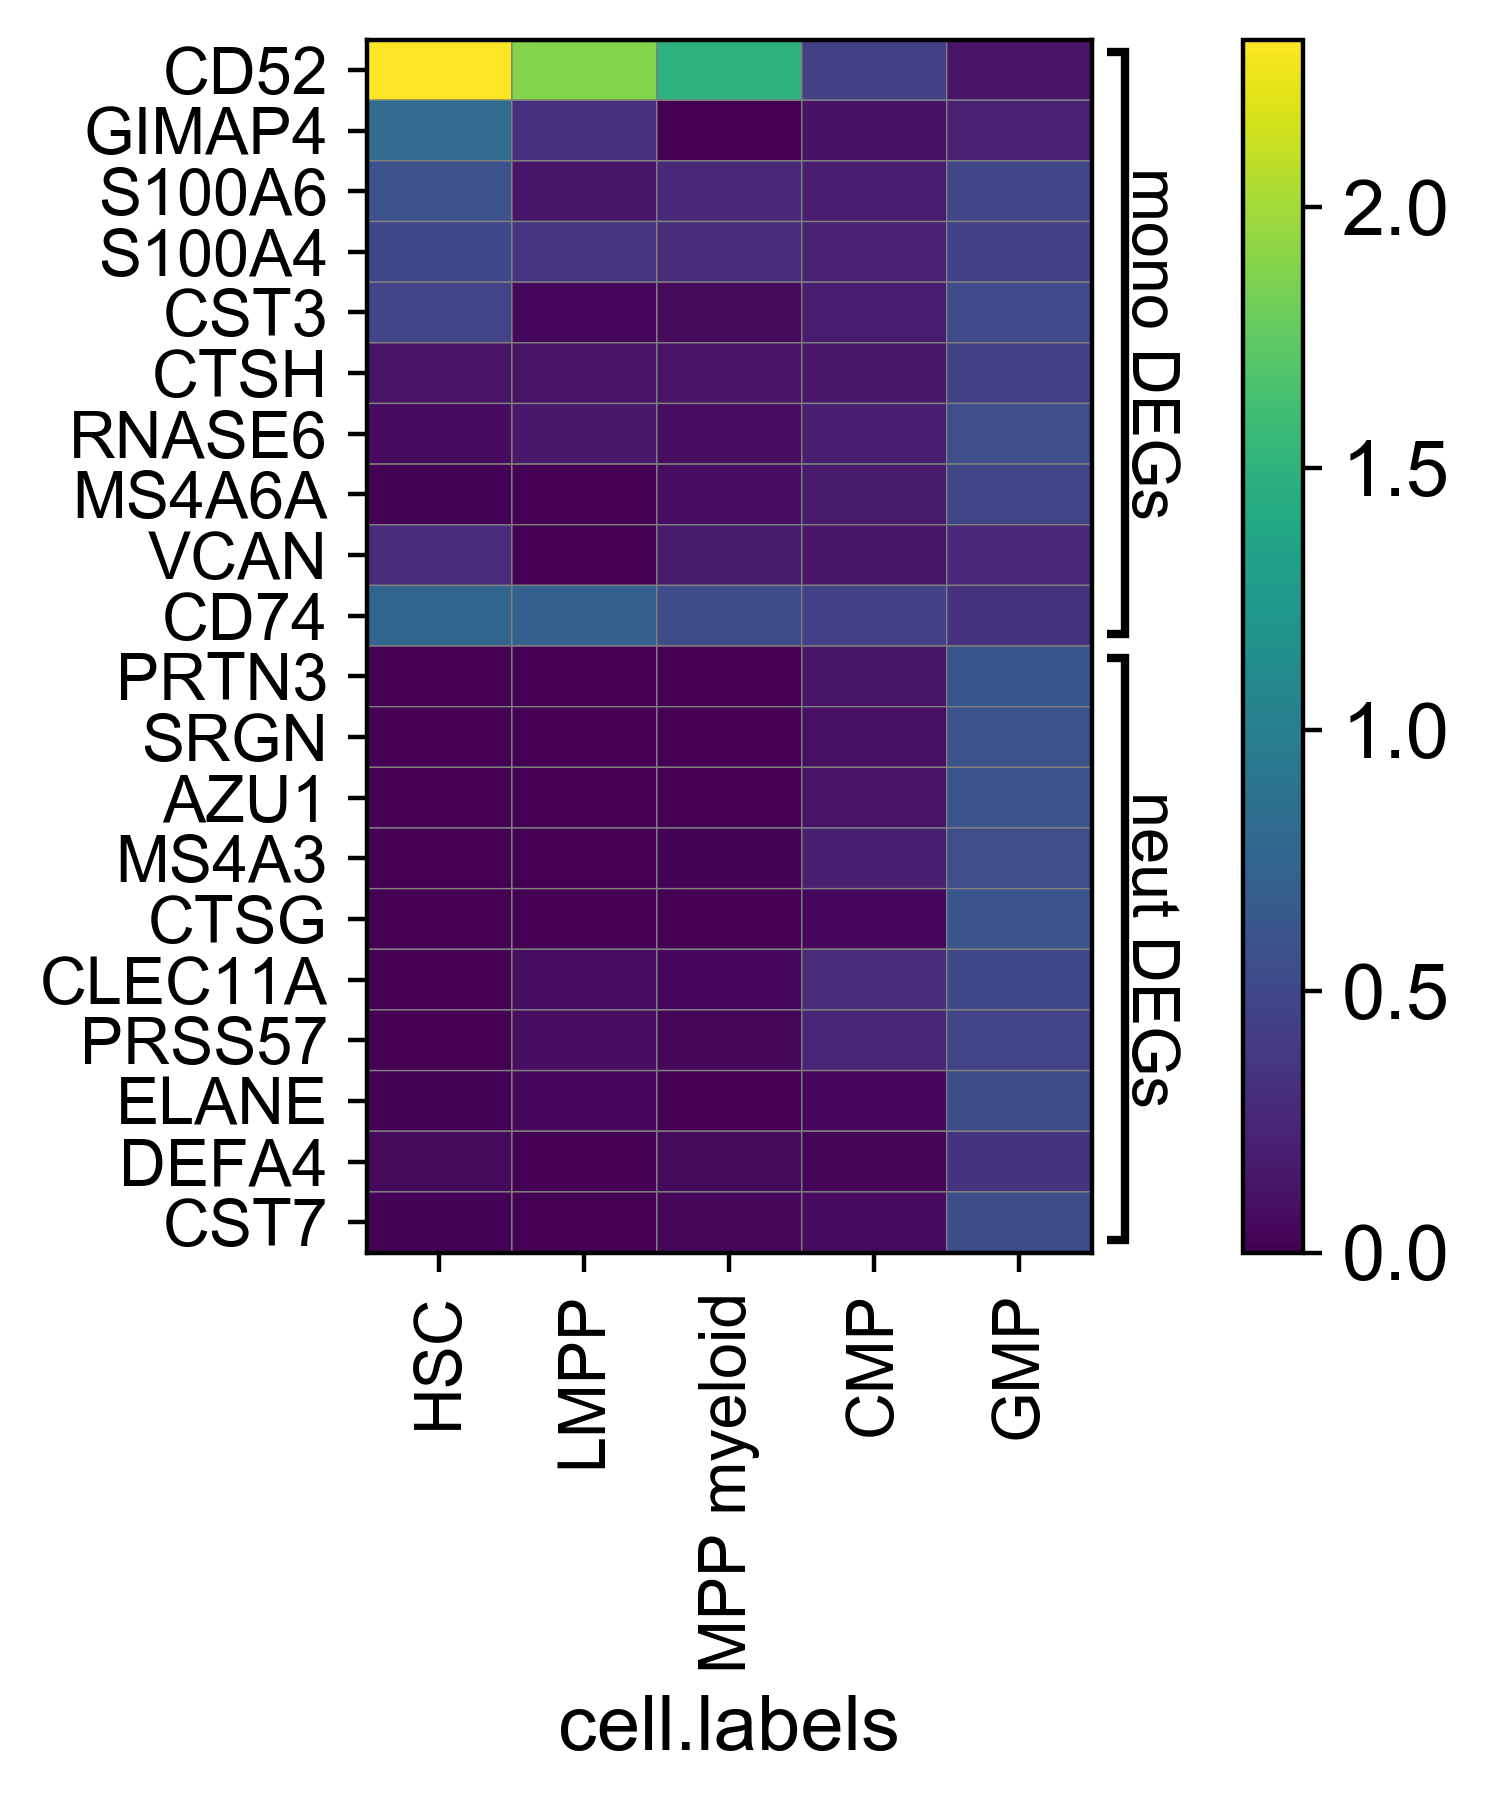

In [16]:
genes = ['CD52', # here are discrete premonocyte DEGs
'GIMAP4',
'S100A6',
'S100A4',
'CST3',
'CTSH',
'RNASE6',
'MS4A6A',
'VCAN',
'CD74',
# here are discrete promyelocyte DEGs
'PRTN3',
'SRGN',
'AZU1',
'MS4A3',
'CTSG',
'CLEC11A',
'PRSS57',
'ELANE',
'DEFA4',
'CST7']

adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['HSC', 'LMPP', 'MPP myeloid', 'CMP', 
                                             'GMP'])

gs = sc.pl.matrixplot(adata, var_names=genes, 
                      save="neut_myeloid_progen_heatmap_by_celltype_20210113.pdf",   
                      groupby='cell.labels', swap_axes=True, use_raw=False, figsize=[3,4], 
                      var_group_positions=[(0,9), (10, 19)], 
                      var_group_labels = ["mono DEGs", "neut DEGs"]) 

# Plot heatmaps of neut progen (per cell, showing neut/mono DEGs)

In [17]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC              92
LMPP             34
MPP myeloid      92
CMP             425
GMP            1281
dtype: int64

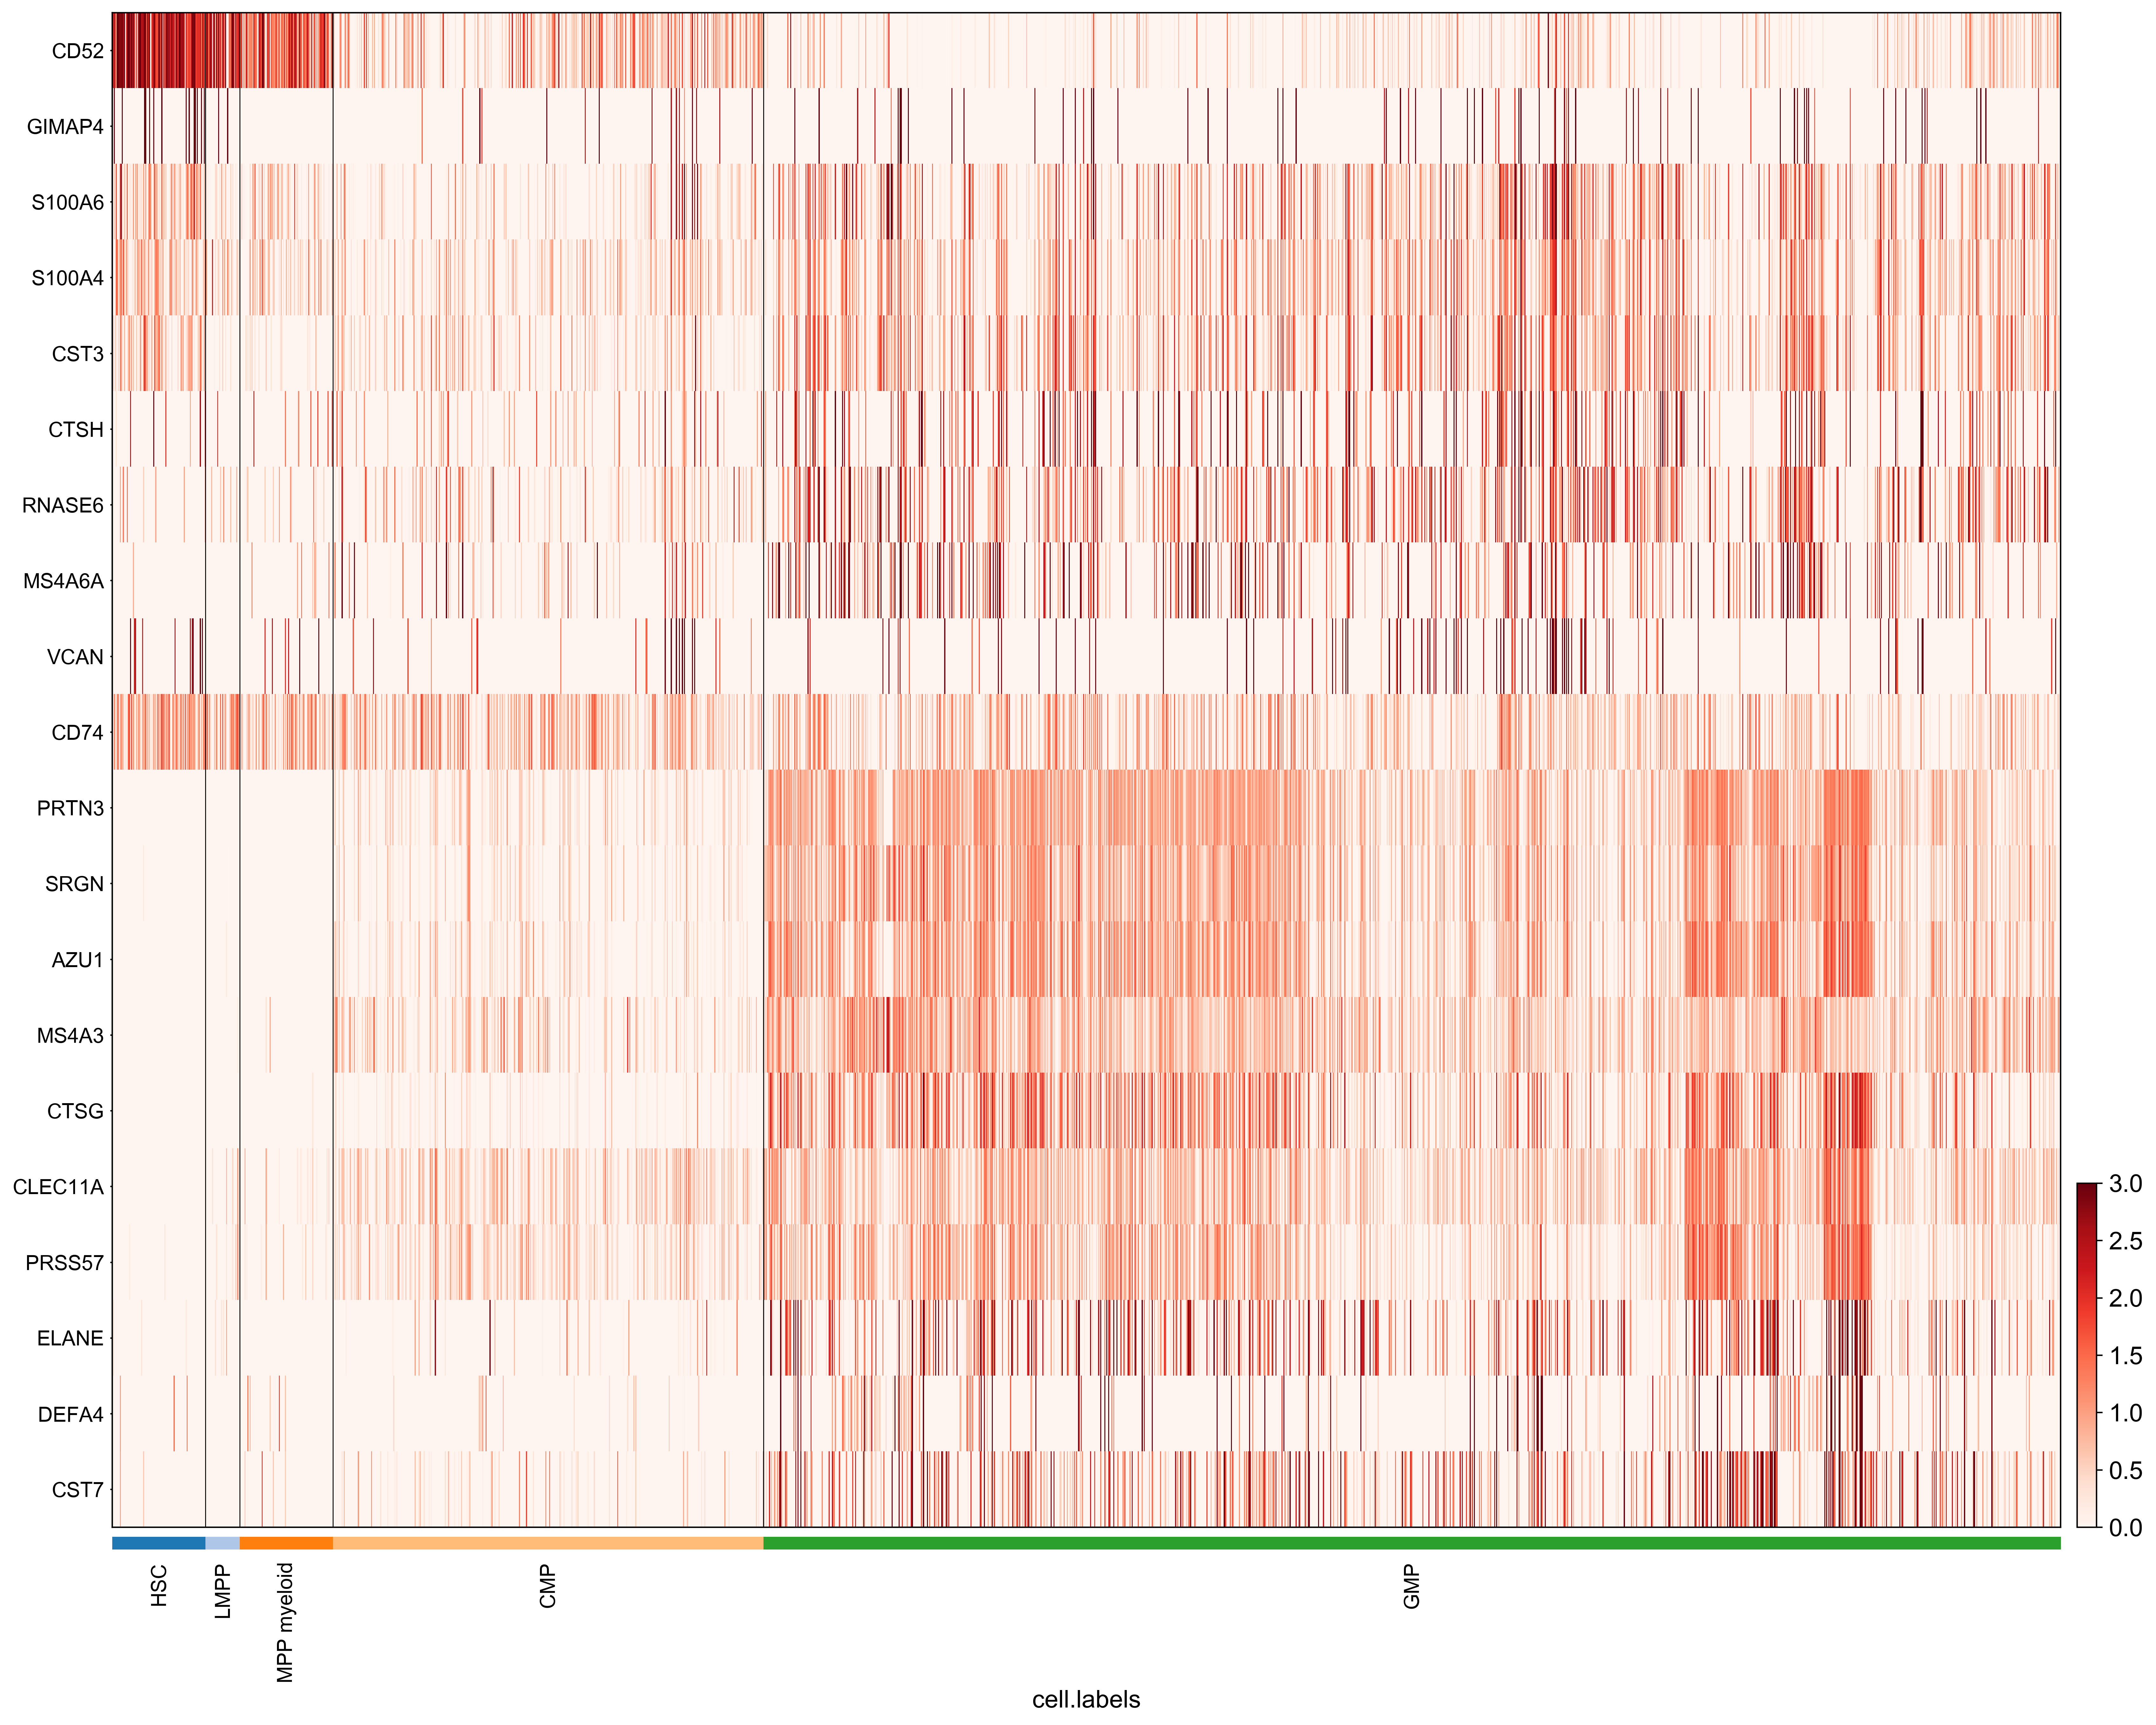

In [18]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['HSC', 'LMPP', 'MPP myeloid', 
                                             'CMP', 'GMP'])

gs = sc.pl.heatmap(adata, var_names=genes, save="neut_myeloid_progen_heatmap_overall_20210113.pdf",   
                      groupby='cell.labels', swap_axes=True, use_raw=False, figsize=[20,16], 
                      cmap ='Reds', vmax=3)

In [19]:
adata.obs["index"] = adata.obs.index
adata.obs["index"] = pd.Categorical(adata.obs["index"])

cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC              92
LMPP             34
MPP myeloid      92
CMP             425
GMP            1281
dtype: int64

In [20]:
subset = adata[adata.obs["cell.labels"].isin(["HSC"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=genes, save="neut_myeloid_progen_heatmap_HSC_20210113.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[0.94,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [21]:
subset = adata[adata.obs["cell.labels"].isin(["LMPP"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=genes, save="neut_myeloid_progen_heatmap_LMPP_20210113.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[0.34,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [22]:
subset = adata[adata.obs["cell.labels"].isin(["MPP myeloid"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=genes, save="neut_myeloid_progen_heatmap_MPP_myeloid_20210113.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[0.94,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [23]:
subset = adata[adata.obs["cell.labels"].isin(["CMP"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=genes, save="neut_myeloid_progen_heatmap_CMP_20210113.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[4.4,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [24]:
subset = adata[adata.obs["cell.labels"].isin(["GMP"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=genes, save="neut_myeloid_progen_heatmap_GMP_20210113.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[13.2,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

# Save the data

In [25]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [26]:
adata.X

<1924x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 6420887 stored elements in Compressed Sparse Row format>

In [27]:
adata.raw.X

<1924x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 7482859 stored elements in Compressed Sparse Row format>

In [28]:
del adata.obs["index"]

In [29]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/figs2d_neut_myeloid_progen_heatmap_20210113.h5ad")